# Import NSIDC sea ice concentration observations, regrid onto OM2 grid (025) and save again

from http://nsidc.org/data/G02202

In [14]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.path as mpath
import numpy as np
%matplotlib inline

import glob

import xesmf
import os
import pandas as pd
import calendar
from tqdm import tqdm_notebook

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37343,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:41877,Total threads: 4
Dashboard: /proxy/38527/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:34333,


### Load observations

In [10]:
timerange = slice(pd.to_datetime('1990-05-01', format='%Y-%m-%d'),
                  pd.to_datetime('1991-04-30', format='%Y-%m-%d'))

In [11]:
def get_sic_obs(pattern, path='/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3', # from http://nsidc.org/data/G02202
                variable='goddard_merged_seaice_conc_monthly', timerange=timerange): 
    '''
    Return a dataarray from the nc files in path/pattern.
    '''
    dataarrays = []
    files = glob.glob(os.path.join(path, pattern))
    for f in tqdm_notebook(files, leave=False, desc='opening files'):
        dataarrays.append(xr.open_dataset(f, decode_times=False)[variable])
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units })

    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0, dataarray<=1)) #, np.nan)
    
    # use the same coord names as access-om2 t grid
    dataarray = dataarray.rename(({'xgrid': 'xt_ocean', 'ygrid': 'yt_ocean'}))
    
    # sort by time and select timerange
    dataarray = dataarray.sortby('time').sel(time=timerange)

    return dataarray

In [12]:
def obs_mm(obs, groupby='time.month'):
    cobs = obs.groupby(groupby).mean('time', skipna=True)
    cobs = cobs.assign_coords({'latitude': obs.latitude.isel(time=0),
                              'longitude': obs.longitude.isel(time=0)})
    return cobs

SH

In [15]:
obs_SH = get_sic_obs('south/monthly/*.nc', timerange=timerange)

opening files:   0%|          | 0/493 [00:00<?, ?it/s]

In [34]:
timerange_all = slice(pd.to_datetime('1979-01-01', format='%Y-%m-%d'),
                  pd.to_datetime('2021-12-31', format='%Y-%m-%d'))
obs_SH_all = get_sic_obs('south/monthly/*.nc', timerange=timerange_all)

opening files:   0%|          | 0/493 [00:00<?, ?it/s]

In [16]:
obs_SH_mm = obs_mm(obs_SH)  # monthly climatologies
obs_SH_avet = obs_SH.mean('time', skipna=True)  # mean for all data

NH

In [17]:
obs_NH = get_sic_obs('north/monthly/*.nc', timerange=timerange)

opening files:   0%|          | 0/493 [00:00<?, ?it/s]

In [37]:
timerange_all = slice(pd.to_datetime('1979-01-01', format='%Y-%m-%d'),
                  pd.to_datetime('2021-12-31', format='%Y-%m-%d'))
obs_NH_all = get_sic_obs('north/monthly/*.nc', timerange=timerange_all)

opening files:   0%|          | 0/493 [00:00<?, ?it/s]

In [18]:
obs_NH_mm = obs_mm(obs_NH)  # monthly climatologies
obs_NH_avet = obs_NH.mean('time', skipna=True)  # mean for all data

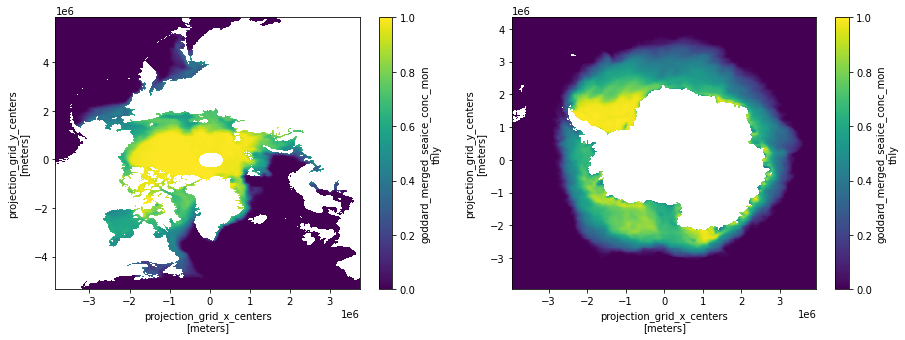

In [23]:
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
obs_NH_avet.plot()

plt.subplot(122)
obs_SH_avet.plot()

### Regrid to model grid

In [8]:
def G02202_obs_regridder(grid_in, grid_out, method='bilinear', **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a NSIDC G02202 NetCDF grid file
    grid_out -- path to a MOM grid file (tracer points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)\
             .rename({'xgrid': 'x', 'ygrid': 'y',
                     'longitude': 'lon', 'latitude': 'lat'})
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
        ds_out_fix = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-temp-1-daily-mean-ym_1958_01.nc')\
                    .rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
        ds_out = ds_out.assign_coords({'x': ds_out_fix['x'], 'y': ds_out_fix['y']})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

In [29]:
%%time
obsfile_SH = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3/south/monthly/seaice_conc_monthly_sh_f08_198708_v03r01.nc'
regrid_SHobs_to_025 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_025.nc')

CPU times: user 124 ms, sys: 38.8 ms, total: 163 ms
Wall time: 299 ms


In [30]:
obsfile_NH = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3/north/monthly/seaice_conc_monthly_nh_f08_198708_v03r01.nc'
regrid_NHobs_to_025 = G02202_obs_regridder(obsfile_NH, '/g/data/ik11/grids/ocean_grid_025.nc')

In [31]:
obs_SH_mm_regrid = regrid_SHobs_to_025(obs_SH_mm)
obs_SH_avet_regrid = regrid_SHobs_to_025(obs_SH_avet)

In [32]:
obs_NH_mm_regrid = regrid_NHobs_to_025(obs_NH_mm)
obs_NH_avet_regrid = regrid_NHobs_to_025(obs_NH_avet)

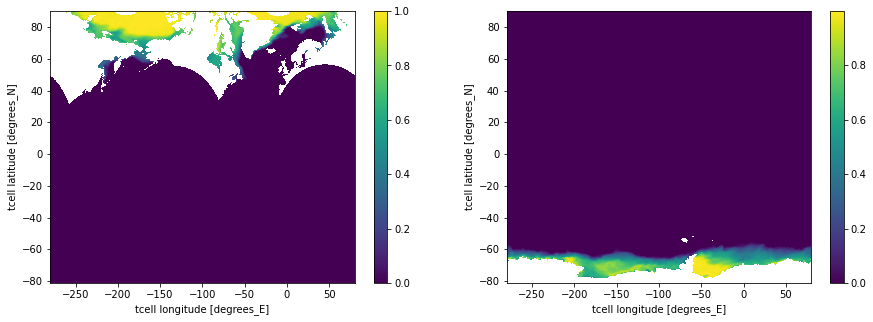

In [33]:
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
obs_NH_avet_regrid.plot()

plt.subplot(122)
obs_SH_avet_regrid.plot()

### Save sea ice concentration (obs) on model grid

In [38]:
obs_NH_all_regrid = regrid_NHobs_to_025(obs_NH_all)

In [39]:
obs_SH_all_regrid = regrid_SHobs_to_025(obs_SH_all)

In [42]:
obs_NH_all_regrid.to_netcdf('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_NH_grid_OM2_025.nc')

In [43]:
obs_SH_all_regrid.to_netcdf('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_SH_grid_OM2_025.nc')